# 1. 전처리 부문

## 1.1 기본 라이브러리 입력 

(1) 확장 라이브러리 설치

In [255]:
# 지도 출력 관련 데이터 
!pip install -q geopandas

# 엑셀 관련 데이터 
!pip3 install xlrd
!pip3 install openpyxl

# null 시각화 라이브러리
!pip3 install missingno

(2) 라이브러리 불러오기

In [113]:
# 기본 전처리 라이브러리
import pandas as pd
import numpy as np

import os

# kakao 좌표 관련 요청 라이브러리
import json
import requests

# 지도 표기 library
import folium

#null check library
import missingno as msno

import math

# 시각화
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

## 1.2 데이터별(전처리)

### 1.2.1 기본 자료 데이터 PATH

In [2]:
path = "./data"
file_list = os.listdir(path)

### 1.2.2 "자동차 등록 자료 통계.xlsx" 관련 자료 전처리

#### 1.2.2.1  한글 제목 변환
엑셀 데이터의 경우 판다스에서 정확하게 잘 처리하지 못하는 경우나 읽기 어려운 경우와 한글의 경우 인코딩 문제가 일부 있어, 관련 부분 제목 변환<p>
    
2020년 01월 자동차 등록자료 통계 --> 2020_01_Car_Info 로 치환

In [93]:
car_file_list = [file for file in file_list if file.endswith('자동차_등록자료_통계.xlsx')]

for car_file in car_file_list:
    src = os.path.join(path, car_file)
    chg_name = car_file.split('_')[0][0:4] + '_' + car_file.split('_')[1][0:-1] + '_' + 'Car_Info' + '.xlsx'
    dst = os.path.join(path, chg_name)
    os.rename(src, dst)

file_list = os.listdir(path)
car_file_list = [file for file in file_list if file.endswith('Car_Info.xlsx')]

변환이 잘되어 파일로 떨어졌는지 확인한다.

In [95]:
print(car_file_list)

['2017_12_Car_Info.xlsx', '2018_01_Car_Info.xlsx', '2018_02_Car_Info.xlsx', '2018_03_Car_Info.xlsx', '2018_04_Car_Info.xlsx', '2018_05_Car_Info.xlsx', '2018_06_Car_Info.xlsx', '2018_07_Car_Info.xlsx', '2018_08_Car_Info.xlsx', '2018_09_Car_Info.xlsx', '2018_10_Car_Info.xlsx', '2018_11_Car_Info.xlsx', '2018_12_Car_Info.xlsx', '2019_01_Car_Info.xlsx', '2019_02_Car_Info.xlsx', '2019_03_Car_Info.xlsx', '2019_04_Car_Info.xlsx', '2019_05_Car_Info.xlsx', '2019_06_Car_Info.xlsx', '2019_07_Car_Info.xlsx', '2019_08_Car_Info.xlsx', '2019_09_Car_Info.xlsx', '2019_10_Car_Info.xlsx', '2019_11_Car_Info.xlsx', '2019_12_Car_Info.xlsx', '2020_01_Car_Info.xlsx', '2020_02_Car_Info.xlsx', '2020_03_Car_Info.xlsx', '2020_04_Car_Info.xlsx', '2020_05_Car_Info.xlsx', '2020_06_Car_Info.xlsx', '2020_07_Car_Info.xlsx', '2020_08_Car_Info.xlsx', '2020_09_Car_Info.xlsx', '2020_10_Car_Info.xlsx']


#### 1.2.1.2 불필요한 데이터 제거 및 2개 데이터로 변환
* 목적 1. 친환경 차량과 비 친환경 차량을 구별하는 인자 추가 
* 목적 2. 불필요 데이터 제거 (의미 없는 값)

(1) 여러개의 엑셀로 분할된 데이터를 한개의 dataframe 으로 합치는 작업

In [96]:
# 각 파일을 1개씩 불러와 전처리 실시 
count = 0
for car_file in car_file_list:
    
    target_file = os.path.join(path, car_file)
    df = pd.read_excel(target_file, engine='openpyxl', sheet_name="10.연료별_등록현황", header = 2)
    df = df.rename(columns={'Unnamed: 2' : '합계'}) # 합계의 경우, 해당 줄에 컬럼명이 없어 추가 함 
    
    if count == 0:
        car_list_df = pd.DataFrame(columns=df.columns)    # 최종 전처리 프레임
        car_list_df['year'] = 0
        car_list_df['month'] = 0
    
    # 소계인 데이터만 추출 (업무용 / 비업무용 등은 제거)
    for i in range(1, len(df) - 17, 17):
        tmp = df[i:i+17].fillna(method='pad')[-1:]
        tmp['year'] = car_file.split('_')[0]
        tmp['month'] = car_file.split('_')[1]
        car_list_df = pd.concat([car_list_df, tmp])
    count += 1

(2) 불필요한 데이터 제거

In [97]:
# 소계 중 한대도 없는 차량의 경우 제거 
car_list_df = car_list_df[car_list_df['계'] != 0.0]

# 불필요한 행 제거 
car_list_df = car_list_df.drop('Unnamed: 21', axis=1)

(3) 친환경 / 비친환경 차량 구분

In [98]:
tmp_lst = list()
for tmp in car_list_df.연료별:
    if (tmp.find('수소') != -1 ) | (tmp.find('전기') != -1):
        tmp_lst.append('친환경')
    else : 
        tmp_lst.append('비친환경')

car_list_df['친환경'] = tmp_lst

(4) 나중에 사용할 것을 대비하여, csv 파일로 생성 해둠 

In [99]:
#csv 형태로 변환 저장 [한글 깨짐 방지를 위해 utf-8 설정]
car_list_df.to_csv(os.path.join(path, 'total_car_info.csv'),mode = 'w',encoding='utf-8-sig')

In [100]:
car_list_df

,연료별,시도별,합계,서울,부산,대구,인천,광주,대전,울산,...,충남,전북,전남,경북,경남,제주,계,year,month,친환경
17,휘발유,소계,계,1600270.0,635449.0,551665.0,673739.0,285769.0,320134.0,275208.0,...,452965.0,358368.0,367161.0,597237.0,777981.0,205253.0,10369752.0,2017,12,비친환경
34,경유,소계,계,1135239.0,535827.0,458852.0,656260.0,262201.0,253864.0,221735.0,...,497950.0,422783.0,499841.0,638956.0,717127.0,215321.0,9576395.0,2017,12,비친환경
51,엘피지,소계,계,301546.0,125327.0,122326.0,145392.0,87891.0,72792.0,40227.0,...,88184.0,96526.0,107845.0,132454.0,145109.0,63027.0,2104675.0,2017,12,비친환경
68,등유,소계,계,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2017,12,비친환경
85,전기,소계,계,4797.0,816.0,2005.0,542.0,548.0,303.0,356.0,...,336.0,336.0,960.0,756.0,1022.0,9206.0,25108.0,2017,12,친환경
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,하이브리드(LPG+전기),소계,계,1835.0,808.0,933.0,764.0,679.0,537.0,513.0,...,753.0,839.0,886.0,1066.0,1078.0,343.0,16488.0,2020,10,친환경
221,하이브리드(CNG+전기),소계,계,51.0,2.0,13.0,39.0,26.0,0.0,46.0,...,0.0,8.0,0.0,31.0,1.0,0.0,326.0,2020,10,친환경
255,수소,소계,계,1431.0,858.0,61.0,448.0,653.0,479.0,1721.0,...,442.0,342.0,108.0,15.0,856.0,0.0,10041.0,2020,10,친환경
272,기타연료,소계,계,6236.0,15355.0,3831.0,12402.0,3517.0,3239.0,4845.0,...,8074.0,4595.0,8835.0,9686.0,8127.0,756.0,124678.0,2020,10,비친환경


### 1.2.3 수소 충전소 위치 데이터 처리  (hyd_charging_df)

* 목표 1. 주소지를 다른 데이터와 합칠수 있게 시 / 도별로 나눈 데이터를 추가한다.
* 목표 2. 지도로 표시할수 있도록 좌표 값을 kakao api를 활용하여 추가한다.

In [10]:
path = "./data"
target_file = os.path.join(path, 'Hydrogen_chariging_station.csv')
hyd_charging_df = pd.read_csv(target_file, encoding='cp949')

In [11]:
hyd_charging_df

,No,충전소명,구분,공급방식,주소,충전소전화번호,용도,비고
0,1,현대자동차㈜ 환경기술연구소,저장식,튜브트레일러,경기 용인 기흥 마북로240번길 17-5(마북동),031-899-3022,연구용,NaN
1,2,한국가스공사 H2/HCNG복합충전소,제조식,개질(NG),인천 연수구 인천신항대로 960,032-810-0388,연구용,미가동
2,3,현대자동차㈜ 남양연구소,저장식,튜브트레일러,경기 화성 현대연구소로 150,NaN,연구용,NaN
3,4,에스앤디㈜-울산수소충전소,저장식,튜브트레일러,울산 남구 장생포고래로 317,052-226-6000,연구용,휴지
4,5,한국교통안전공단 자동차성능연구소,저장식,튜브트레일러,경기 화성 송산면 삼존로 200,031-369-1173,연구용,미가동
5,6,현대자동차㈜ 양재그린에너지스테이션,저장식,튜브트레일러,서울 서초구 바우뫼로12길 73,02-2058-1351,상업용,휴지
6,7,서울특별시 상암수소스테이션,제조식,개질(NG+매립가스),서울 마포구 하늘공원로 86,02-3151-0336,상업용,NaN
7,8,한국에너지기술연구원,제조식,수전해,전북 부안군 하서면 신재생에너지로 20-41,063-580-1670,연구용,휴지
8,9,㈜덕양 매암수소충전소,저장식,튜브트레일러,울산 남구 장생포고래로29번길 5,070-4421-1688,상업용,NaN
9,10,이엠솔루션㈜ 대구경북지점,제조식,수전해,대구 북구 조야로2길 41,055-239-9026,상업용,휴지


#### (1) 주소지를 분리한다. 
<p>주소지는 2가지 특징을 지니고 있다.</p>
<ol> 
    <li> 도에 속한 주소는 2가지 값을 지닌다.</li>
    <li> 시에 속한 주소는 1가지 값을 지닌다. </li>
</ol>
다른 데이터를 기준으로 시도 , 지역 구분으로 나누어 표기하기에 동일하게 표기한다. 

In [12]:
tmp_city = list()
tmp_location = list()
for address in hyd_charging_df.주소:
    tmp =  address.split()
    if tmp[0] in ('경기', '경기도', '강원', '강원도', '충남', '충북', '경남', '경북', '전북', '전남' ):
        tmp_city.append(tmp[0].replace('도', '').replace('시', ''))
        tmp_location.append(tmp[1].replace('시', '').replace('군', ''))
    else : 
        tmp_city.append(tmp[0].replace('시', '').replace('군', ''))
        tmp_location.append(tmp[0].replace('시', '').replace('군', ''))            

hyd_charging_df['시도'] = tmp_city
hyd_charging_df['지역'] = tmp_location

In [13]:
hyd_charging_df

,No,충전소명,구분,공급방식,주소,충전소전화번호,용도,비고,시도,지역
0,1,현대자동차㈜ 환경기술연구소,저장식,튜브트레일러,경기 용인 기흥 마북로240번길 17-5(마북동),031-899-3022,연구용,NaN,경기,용인
1,2,한국가스공사 H2/HCNG복합충전소,제조식,개질(NG),인천 연수구 인천신항대로 960,032-810-0388,연구용,미가동,인천,인천
2,3,현대자동차㈜ 남양연구소,저장식,튜브트레일러,경기 화성 현대연구소로 150,NaN,연구용,NaN,경기,화성
3,4,에스앤디㈜-울산수소충전소,저장식,튜브트레일러,울산 남구 장생포고래로 317,052-226-6000,연구용,휴지,울산,울산
4,5,한국교통안전공단 자동차성능연구소,저장식,튜브트레일러,경기 화성 송산면 삼존로 200,031-369-1173,연구용,미가동,경기,화성
5,6,현대자동차㈜ 양재그린에너지스테이션,저장식,튜브트레일러,서울 서초구 바우뫼로12길 73,02-2058-1351,상업용,휴지,서울,서울
6,7,서울특별시 상암수소스테이션,제조식,개질(NG+매립가스),서울 마포구 하늘공원로 86,02-3151-0336,상업용,NaN,서울,서울
7,8,한국에너지기술연구원,제조식,수전해,전북 부안군 하서면 신재생에너지로 20-41,063-580-1670,연구용,휴지,전북,부안
8,9,㈜덕양 매암수소충전소,저장식,튜브트레일러,울산 남구 장생포고래로29번길 5,070-4421-1688,상업용,NaN,울산,울산
9,10,이엠솔루션㈜ 대구경북지점,제조식,수전해,대구 북구 조야로2길 41,055-239-9026,상업용,휴지,대구,대구


#### (2) 위도 경도 추가하기

위도 경도는 주소지로 나온 정보를 kakao api를 활용하여 검색한 후 위도 경도를 획득한다. <p>
    
참고 URL : https://medium.com/@john_analyst/%ED%8C%8C%EC%9D%B4%EC%8D%AC%EC%9D%84-%ED%99%9C%EC%9A%A9%ED%95%9C-%EC%B9%B4%EC%B9%B4%EC%98%A4-api%EB%A1%9C-%EC%9C%84%EA%B2%BD%EB%8F%84-%EA%B5%AC%ED%95%98%EA%B8%B0-69bc51697753

RestAPI=	0f187fa9603bee6f574b613cdb8f525d <p>
code=OLlwbTIfs9G7Nxo1CWhVsLBftdt-dflEMvkxyqHa7AkMnlItQ45L700dPPRbTs6oWKhxpQo9dZsAAAF2JwbVTg <p>

https://kauth.kakao.com/oauth/token?grant_type=authorization_code&client_id=0f187fa9603bee6f574b613cdb8f525d&redirect_uri=http://localhost:8888&code=OLlwbTIfs9G7Nxo1CWhVsLBftdt-dflEMvkxyqHa7AkMnlItQ45L700dPPRbTs6oWKhxpQo9dZsAAAF2JwbVTg

KAKAO API auth 인증 성공
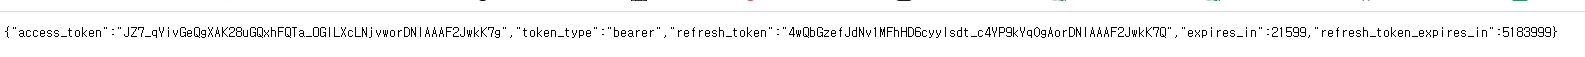

In [44]:
def getLatLng(addr):
    url = 'https://dapi.kakao.com/v2/local/search/address.json?query=' + addr
    headers = {"Authorization": "KakaoAK 073a393656181c6073880062d3507191"}
    result = json.loads(str(requests.get(url, headers=headers).text))
    match_first = result['documents'][0]['address']
    return float(match_first['y']), float(match_first['x'])

location = getLatLng('서울 마포구 모래내로1길 20')

<b>위도 경도 획득 테스트</b>

In [45]:
print(location[0], location[1])

37.5656948713242 126.903284318892


##### 1) 전체 경로가  좌표 변환 되지 않아 불가한 주소는 근처 지역으로 수동 변환한다.

이를 위해, 불가한 좌표만 exception 으로 받아내어 확인한다.

In [42]:
latitude_lst = list()
longitude_lst = list()
falut_location = list()
for i in range(len(hyd_charging_df.주소)):
    try:
        location = getLatLng(hyd_charging_df.주소[i])
        latitude_lst.append(location[0])
        longitude_lst.append(location[1])
    except Exception as e:
        falut_location.append((i, hyd_charging_df.주소[i]))

In [43]:
falut_location

[(1, '인천 연수구 인천신항대로 960'), (9, '대구 북구 조야로2길 41')]

##### 2) 아래 경로의 대해서는 구글 검색을 통해 변환한다. (정확한 주소가 없음으로)
인천 연수구 인천신항대로 960 --> 인천 연수구 인천신항대로 950 <p>
대구 북구 조야로2길 41 --> 대구 북구 조야로2길 55 <p>

In [18]:
location = getLatLng('인천 연수구 인천신항대로 950')
latitude_lst.insert(falut_location[0][0],location[0])
longitude_lst.insert(falut_location[0][0],location[1])

In [19]:
location = getLatLng('대구 북구 조야로2길 55')
latitude_lst.insert(falut_location[1][0],location[0])
longitude_lst.insert(falut_location[1][0],location[1])

In [20]:
latitude_lst[0] , longitude_lst[0]

(37.307586522662, 127.135662910913)

In [21]:
hyd_charging_df['위도'] = latitude_lst
hyd_charging_df['경도'] = longitude_lst

In [22]:
hyd_charging_df

,No,충전소명,구분,공급방식,주소,충전소전화번호,용도,비고,시도,지역,위도,경도
0,1,현대자동차㈜ 환경기술연구소,저장식,튜브트레일러,경기 용인 기흥 마북로240번길 17-5(마북동),031-899-3022,연구용,NaN,경기,용인,37.307587,127.135663
1,2,한국가스공사 H2/HCNG복합충전소,제조식,개질(NG),인천 연수구 인천신항대로 960,032-810-0388,연구용,미가동,인천,인천,37.351717,126.613254
2,3,현대자동차㈜ 남양연구소,저장식,튜브트레일러,경기 화성 현대연구소로 150,NaN,연구용,NaN,경기,화성,37.159398,126.813525
3,4,에스앤디㈜-울산수소충전소,저장식,튜브트레일러,울산 남구 장생포고래로 317,052-226-6000,연구용,휴지,울산,울산,35.507446,129.383761
4,5,한국교통안전공단 자동차성능연구소,저장식,튜브트레일러,경기 화성 송산면 삼존로 200,031-369-1173,연구용,미가동,경기,화성,37.228653,126.768241
5,6,현대자동차㈜ 양재그린에너지스테이션,저장식,튜브트레일러,서울 서초구 바우뫼로12길 73,02-2058-1351,상업용,휴지,서울,서울,37.468378,127.034374
6,7,서울특별시 상암수소스테이션,제조식,개질(NG+매립가스),서울 마포구 하늘공원로 86,02-3151-0336,상업용,NaN,서울,서울,37.571598,126.881674
7,8,한국에너지기술연구원,제조식,수전해,전북 부안군 하서면 신재생에너지로 20-41,063-580-1670,연구용,휴지,전북,부안,35.712072,126.599258
8,9,㈜덕양 매암수소충전소,저장식,튜브트레일러,울산 남구 장생포고래로29번길 5,070-4421-1688,상업용,NaN,울산,울산,35.509879,129.367415
9,10,이엠솔루션㈜ 대구경북지점,제조식,수전해,대구 북구 조야로2길 41,055-239-9026,상업용,휴지,대구,대구,35.907818,128.583034


#### 3) 실제 지도상 해당 위치를 표기 한다.

In [23]:
# 지도 시작 지점을 주기 위해서
lat = hyd_charging_df['위도'].mean()
long = hyd_charging_df['경도'].mean()

m = folium.Map([lat,long], zoom_start=7)

for i in range(len(hyd_charging_df)):
    lat = hyd_charging_df.loc[i,'위도']
    loc = hyd_charging_df.loc[i,'경도']
    title = hyd_charging_df.loc[i,'충전소명']
    
    folium.Marker([lat, loc], tooltip=title).add_to(m)

# 한글 확인이 필요한 경우 아래 html 확인
m.save('hyd_charging_location.html')
m

### 1.2.4 올해 수소차의 구매 동향 데이터(hyd_supply_df)

<b>본 데이터의 가공 사항</b>
<ol>
    <li> NULL DATA 제거</li>    
    <li> 차종에 따른 분류 데이터를 1개의 데이터로 변환한다.</li>    
    <li> 지역 구분 데이터 상 특별시 , 광역시 등을 제외한다.</li>
</ol>

In [24]:
path = "./data"
target_file = os.path.join(path, 'Hydrogen_car_supply_status.csv')
hyd_supply_df = pd.read_csv(target_file)

In [25]:
hyd_supply_df

,시도,지역구분,차종,민간공고대수,접수대수,출고대수,출고잔여대수
0,서울,서울특별시,승용,1211,1013.0,894.0,317.0
1,서울,서울특별시,승합,4,4.0,0.0,4.0
2,부산,부산광역시,승용,400,345.0,335.0,65.0
3,부산,부산광역시,승합,15,5.0,0.0,15.0
4,대구,대구광역시,전체,50,56.0,50.0,0.0
...,...,...,...,...,...,...,...
81,NaN,NaN,NaN,NaN,NaN,NaN,NaN
82,NaN,NaN,NaN,NaN,NaN,NaN,NaN
83,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 1) 아예 data 상 null 인 데이터 제거

In [26]:
hyd_supply_df = hyd_supply_df[hyd_supply_df.시도.notnull()]

In [27]:
hyd_supply_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77 entries, 0 to 76
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   시도      77 non-null     object 
 1   지역구분    77 non-null     object 
 2   차종      77 non-null     object 
 3   민간공고대수  77 non-null     object 
 4   접수대수    77 non-null     float64
 5   출고대수    77 non-null     float64
 6   출고잔여대수  77 non-null     float64
dtypes: float64(3), object(4)
memory usage: 4.8+ KB


In [28]:
hyd_supply_df['민간공고대수'] = hyd_supply_df['민간공고대수'].astype('float')

<ipython-input-28-7ef014515d82>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hyd_supply_df['민간공고대수'] = hyd_supply_df['민간공고대수'].astype('float')


#### 2) 차종 구분을 없애고 하나의 데이터로 만든다.

In [29]:
hyd_supply_df = hyd_supply_df.groupby(['시도','지역구분']).sum()
hyd_supply_df

민간공고대수   접수대수   출고대수  출고잔여대수
시도 지역구분                              
강원 고성군      4.0    4.0    4.0     0.0
   동해시     10.0   10.0   10.0     0.0
   삼척시    169.0  180.0  169.0     0.0
   속초시    127.0  104.0   90.0    37.0
   원주시     50.0   50.0   50.0     0.0
...         ...    ...    ...     ...
충북 괴산군     30.0    4.0    0.0    30.0
   음성군    145.0   17.0   16.0   129.0
   제천시    100.0    6.0    6.0    94.0
   청주시    287.0  134.0  131.0   156.0
   충주시    100.0   34.0   34.0    66.0

[75 rows x 4 columns]

In [30]:
hyd_supply_df.reset_index(level=['시도','지역구분'], inplace = True)

In [31]:
hyd_supply_df

,시도,지역구분,민간공고대수,접수대수,출고대수,출고잔여대수
0,강원,고성군,4.0,4.0,4.0,0.0
1,강원,동해시,10.0,10.0,10.0,0.0
2,강원,삼척시,169.0,180.0,169.0,0.0
3,강원,속초시,127.0,104.0,90.0,37.0
4,강원,원주시,50.0,50.0,50.0,0.0
...,...,...,...,...,...,...
70,충북,괴산군,30.0,4.0,0.0,30.0
71,충북,음성군,145.0,17.0,16.0,129.0
72,충북,제천시,100.0,6.0,6.0,94.0
73,충북,청주시,287.0,134.0,131.0,156.0


#### 3) 시 / 도 / 군등의 데이터를 제거한다.

본 데이터의 특징은, 경기, 경북 등의 도가 들어가지 않은 데이터의 경우 시도를 그대로 사용하면 지역구분에서 제거가 된다.<p>
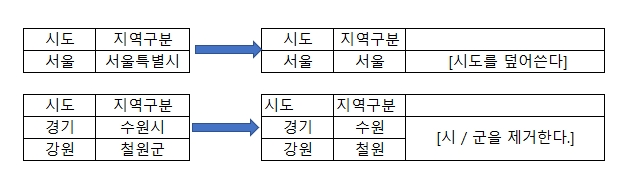

In [32]:
tmp_location = list()
for i in range(len(hyd_supply_df)):
    if hyd_supply_df.loc[i, '시도'] in ('경기', '경기도', '강원', '강원도', '충남', '충북', '경남', '경북', '전북', '전남' ):
        tmp_location.append(hyd_supply_df.loc[i, '지역구분'][:-1])
    else :
        tmp_location.append(hyd_supply_df.loc[i, '시도'])

hyd_supply_df['지역구분'] = tmp_location

In [33]:
hyd_supply_df.head(5)

,시도,지역구분,민간공고대수,접수대수,출고대수,출고잔여대수
0,강원,고성,4.0,4.0,4.0,0.0
1,강원,동해,10.0,10.0,10.0,0.0
2,강원,삼척,169.0,180.0,169.0,0.0
3,강원,속초,127.0,104.0,90.0,37.0
4,강원,원주,50.0,50.0,50.0,0.0


### 1.2.4 전기 충전소 현황 데이터 (elec_charging_station_df)

<b>본 데이터의 가공 사항</b>
<ol>
    <li> 이상 행 관련 행 명칭 변경 </li>    
    <li> 결측치 가공 (제거 / 추가)</li>    
    <li> 지역 구분을 세부에서 시도 수준 추가</li>
</ol>

In [34]:
path = "./data"
target_file = os.path.join(path, 'ELEC_Charging_station.csv')
elec_charging_station_df = pd.read_csv(target_file, encoding='cp949')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3641 entries, 0 to 3640
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   충전소ID   3641 non-null   int64  
 1   충전소명    3641 non-null   object 
 2   충전소주소   3600 non-null   object 
 3   상세주소    3571 non-null   object 
 4   위도      3597 non-null   float64
 5   위도.1    3597 non-null   float64
 6   이용가능시간  3569 non-null   object 
 7   연락처     3611 non-null   object 
dtypes: float64(2), int64(1), object(5)
memory usage: 227.7+ KB


<AxesSubplot:>

C:\Users\kerne\.conda\envs\geo_env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 52649 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\kerne\.conda\envs\geo_env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 51204 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\kerne\.conda\envs\geo_env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49548 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\kerne\.conda\envs\geo_env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 47749 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\kerne\.conda\envs\geo_env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 51452 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\kerne\.conda\envs\geo_env\lib\site-packages\matplotlib\backends\ba

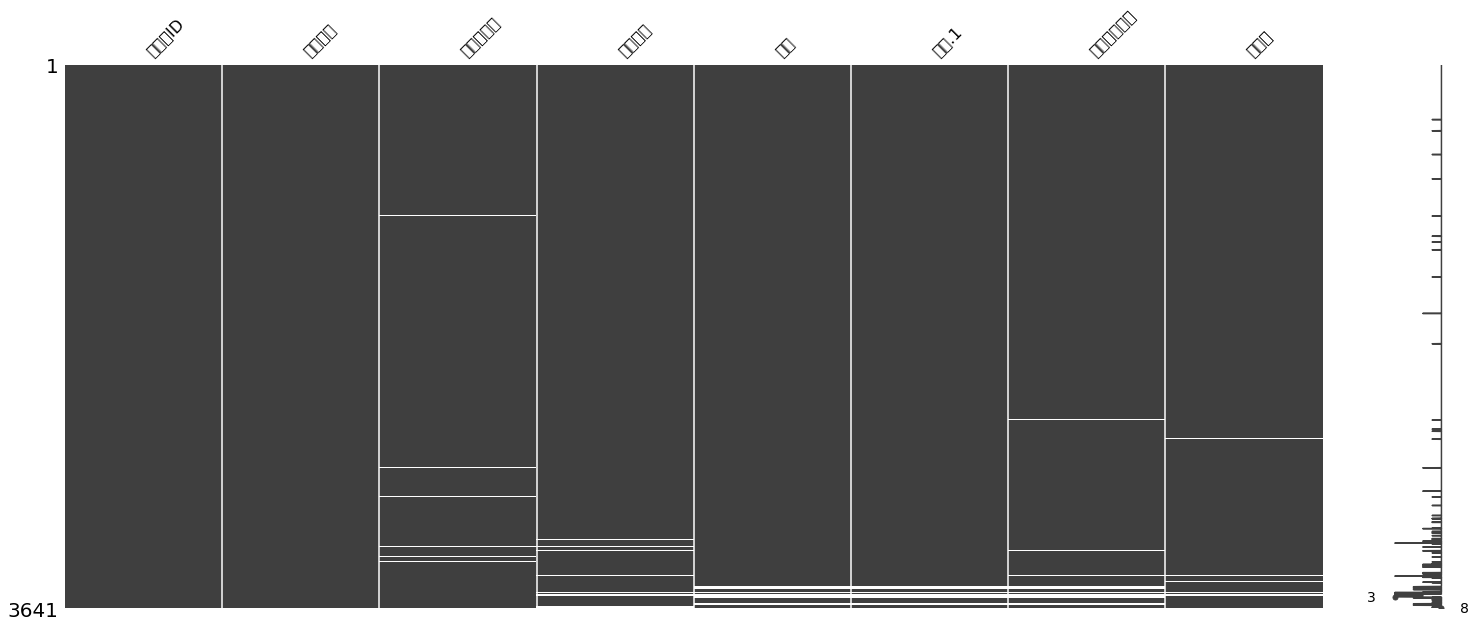

In [35]:
elec_charging_station_df.info()

msno.matrix(elec_charging_station_df)

데이터상 결측치 3구간을 처리해야함을 확인할 수 있다. <p>
1. 충전소주소
2. 위도 / 경도

#### 1) 위도.1 (x) -> 경도로 column 변경

In [36]:
elec_charging_station_df = elec_charging_station_df.rename(columns={'위도.1' : '경도'})
elec_charging_station_df.head(3)

,충전소ID,충전소명,충전소주소,상세주소,위도,경도,이용가능시간,연락처
0,2891,역삼래미안,서울 강남구 역삼동 757,지하2층 107동 3-4라인,37.497198,127.050153,24시간,1899-2100
1,2892,현대까르띠에710아파트,서울 강남구 역삼동 710,지하주차장 진입 후 바로 좌측,37.501522,127.044931,24시간,1899-2100
2,2904,열매마을5단지,대전광역시 유성구 지족동 877,지하주차장,36.377466,127.319577,24시간,1899-2100


In [37]:
elec_charging_station_df.columns

Index(['충전소ID', '충전소명', '충전소주소', '상세주소', '위도', '경도', '이용가능시간', '연락처'], dtype='object')

#### 2) 결측치 가공 (제거 / 추가)

<b>1. 주소 상 결측치의 경우, 위도 경도를 주소로 변환하여, 판단하는 방법도 있다고 생각하나, 데이터 정확성 검토의 시간이 다소 오래걸려 제거한다. </b>

In [38]:
elec_charging_station_df.충전소주소.isnull().value_counts()

False    3600
True       41
Name: 충전소주소, dtype: int64

In [39]:
elec_charging_station_df = elec_charging_station_df[elec_charging_station_df.충전소주소.notnull()]

In [40]:
elec_charging_station_df.충전소주소.isnull().value_counts()

False    3600
Name: 충전소주소, dtype: int64

<b>2. 위도 경도가 없는 대상의 값 변경 </b>

위도 경도가 없는 대상의 경우, 우선은 충전소 주소로 위치를 판단하고, 해당 부분도 판단이 불가한 경우 제거하기로 한다.

In [54]:
not_found_idx_lst = list()
for i in elec_charging_station_df.index:
    if math.isnan(elec_charging_station_df.loc[i,'경도']):
        try:
            location = getLatLng(elec_charging_station_df.충전소주소[i])
            elec_charging_station_df.loc[i,'위도'] = location[0]
            elec_charging_station_df.loc[i,'경도'] = location[1]
        except Exception as e:
            not_found_idx_lst.append(i)

elec_charging_station_df = elec_charging_station_df.drop(not_found_idx_lst)

In [55]:
elec_charging_station_df

,충전소ID,충전소명,충전소주소,상세주소,위도,경도,이용가능시간,연락처
0,2891,역삼래미안,서울 강남구 역삼동 757,지하2층 107동 3-4라인,3.749720e+01,1.270502e+02,24시간,1899-2100
1,2892,현대까르띠에710아파트,서울 강남구 역삼동 710,지하주차장 진입 후 바로 좌측,3.750152e+01,1.270449e+02,24시간,1899-2100
2,2904,열매마을5단지,대전광역시 유성구 지족동 877,지하주차장,3.637747e+01,1.273196e+02,24시간,1899-2100
3,2906,서진아파트,경상남도 창원시 마산회원구 내서읍 상곡리 67,지하1층주차장,3.524164e+01,1.285043e+02,24시간,1899-2100
4,2907,팜스프링아파트,경기도 파주시 금촌동 7,119동 지하3층 B33,3.777181e+01,1.267753e+02,24시간,1899-2100
...,...,...,...,...,...,...,...,...
3636,4123,단양군청,충청북도 단양군 단양읍 별곡리 300,NaN,3.300000e+01,1.240000e+02,24시간,1899-2100
3637,4128,가경벽산아파트,충청북도 청주시 흥덕구 가경동 762,NaN,3.300000e+01,1.240000e+02,24시간,1899-2100
3638,4106,화도수동행정복지센터,경기도 남양주시 화도읍 마석우리 548,옥외주차장,3.739262e+06,1.271804e+07,24시간,1899-2100
3639,4125,음성군 근로자종합복지관,충청북도 음성군 대소면 태생리 605,NaN,3.300000e+01,1.240000e+02,24시간,1899-2100


## 3) 지역 구분을 세부데이터를 바탕으로 시도 수준 추가 

#### 데이터 값 확인

In [56]:
tmp = list()
for i in elec_charging_station_df.index:
    address = elec_charging_station_df.loc[i, '충전소주소']
    tmp.append(address.split()[0])

tmp = set(tmp)
print(tmp)

{'강원도', '충남', '전라북도', '충청북도', '경북', '대구광역시', '경기도', '전남', '충북', '경기', '대전광역시', '경상남도', '광주광역시', '서울시', '서울', '다산동', '세종특별자치시', '울산광역시', '전라남도', '부산', '부산광역시', '대구', '경남', '인천광역시', '풍산동', '서울특별시', '전북', '울산', '제주특별자치도', '부산시', '강원', '경상북도', '대전', '인천', '광주', '충청남도'}


시도 데이터 가공 <p>
 기존 양식과 동일하게 데이터 가공 

In [62]:
tmp = list()
for i in elec_charging_station_df.index:
    address = elec_charging_station_df.loc[i, '충전소주소'].split()
    if address[0] in ('경기도', '강원도'):
        tmp.append(address[0][:-1])
    elif address[0] in ('경상남도', '경상북도', '충청남도', '충청북도', '전라남도', '전라북도'):
        tmp.append(address[0][0::2])
    elif address[0] in ('경남', '경북', '충남', '충북', '전남', '전북', '강원', '경기'):
        tmp.append(address[0])
    else:
        tmp.append(address[0][:2])

elec_charging_station_df['시도'] = tmp
print(set(tmp))

{'충남', '경북', '다산', '제주', '전남', '충북', '세종', '경기', '서울', '부산', '대구', '경남', '풍산', '전북', '울산', '강원', '대전', '인천', '광주'}


도시명 내의 다산과 풍산의 경우 시의 이름이 제외되어 있는 것으로 추정됨 <p>

이에 따라, 이의 대한 처리는 우선적으로는 제거 하는 방향으로 수행

In [70]:
elec_charging_station_df = elec_charging_station_df[(elec_charging_station_df['시도'] != '다산') & (elec_charging_station_df['시도'] != '풍산')]
elec_charging_station_df

,충전소ID,충전소명,충전소주소,상세주소,위도,경도,이용가능시간,연락처,시도
0,2891,역삼래미안,서울 강남구 역삼동 757,지하2층 107동 3-4라인,3.749720e+01,1.270502e+02,24시간,1899-2100,서울
1,2892,현대까르띠에710아파트,서울 강남구 역삼동 710,지하주차장 진입 후 바로 좌측,3.750152e+01,1.270449e+02,24시간,1899-2100,서울
2,2904,열매마을5단지,대전광역시 유성구 지족동 877,지하주차장,3.637747e+01,1.273196e+02,24시간,1899-2100,대전
3,2906,서진아파트,경상남도 창원시 마산회원구 내서읍 상곡리 67,지하1층주차장,3.524164e+01,1.285043e+02,24시간,1899-2100,경남
4,2907,팜스프링아파트,경기도 파주시 금촌동 7,119동 지하3층 B33,3.777181e+01,1.267753e+02,24시간,1899-2100,경기
...,...,...,...,...,...,...,...,...,...
3636,4123,단양군청,충청북도 단양군 단양읍 별곡리 300,NaN,3.300000e+01,1.240000e+02,24시간,1899-2100,충북
3637,4128,가경벽산아파트,충청북도 청주시 흥덕구 가경동 762,NaN,3.300000e+01,1.240000e+02,24시간,1899-2100,충북
3638,4106,화도수동행정복지센터,경기도 남양주시 화도읍 마석우리 548,옥외주차장,3.739262e+06,1.271804e+07,24시간,1899-2100,경기
3639,4125,음성군 근로자종합복지관,충청북도 음성군 대소면 태생리 605,NaN,3.300000e+01,1.240000e+02,24시간,1899-2100,충북


<b>시도 부문 데이터 가공. </b>

In [71]:
elec_charging_station_df.head(3)

,충전소ID,충전소명,충전소주소,상세주소,위도,경도,이용가능시간,연락처,시도
0,2891,역삼래미안,서울 강남구 역삼동 757,지하2층 107동 3-4라인,37.497198,127.050153,24시간,1899-2100,서울
1,2892,현대까르띠에710아파트,서울 강남구 역삼동 710,지하주차장 진입 후 바로 좌측,37.501522,127.044931,24시간,1899-2100,서울
2,2904,열매마을5단지,대전광역시 유성구 지족동 877,지하주차장,36.377466,127.319577,24시간,1899-2100,대전


In [80]:
tmp = list()
for i in elec_charging_station_df.index:
    address = elec_charging_station_df.loc[i, '충전소주소']
    tmp.append(address.split()[1])

tmp = set(tmp)
print(tmp)

{'고운동', '건입동', '강서구', '광산구', '제주시', '연동면', '연천군', '합천군', '포천시', '옥천군', '화순군', '서대문구', '평택시', '금정구', '금천구', '홍천군', '해남군', '창녕군', '창원시', '아름동', '진주시', '포항시', '성남시', '광진구', '과천시', '남구', '화천군', '김포시', '송파구', '관악구', '경산시', '사천시', '강화군', '칠곡군', '전주시', '진천군', '나성동', '고양시', '예천군', '하동군', '달서구', '밀양시', '고성읍', '논산시', '안동시', '통영시', '진안군', '영천시', '문경시', '아산시', '울진군', '완도군', '중랑구', '김천시', '동구', '영광군', '안산시', '정선군', '금산군', '의령군', '중구', '강릉시', '군산시', '광주시', '함안군', '고성군', '청송군', '성동구', '영월군', '부여군', '청주시', '남동구', '삼척시', '수성구', '소담동', '강진군', '인제군', '평창군', '신안군', '강남구', '성북구', '조치원읍', '양양군', '횡성군', '고흥군', '연수구', '증평군', '서천군', '종로구', '사하구', '태안군', '동해시', '여주시', '안양시', '남해군', '노원구', '거제시', '양주시', '나주시', '서구', '군포시', '여수시', '사상구', '계룡시', '순천시', '해운대구', '예산군', '화성시', '송산면', '부산진구', '김제시', '달성군', '광명시', '수원시', '울주군', '보은군', '시흥시', '의왕시', '광양시', '대평동', '함평군', '강동구', '도담동', '영도구', '유성구', '괴산군', '청도군', '고령군', '구로구', '이천시', '익산시', '동래구', '양산시', '안성시', '음성군', '영암군', '산청군', '절재로', '동작구', '충주시', '고창군', '제천시', '서초구'

In [84]:
tmp = list()
for i in elec_charging_station_df.index:
    address = elec_charging_station_df.loc[i, '시도']
    if address in ('경남', '경북', '충남', '충북', '전남', '전북', '강원', '경기'):
        tmp.append(elec_charging_station_df.loc[i, '충전소주소'].split()[1][:-1])
    else:
        tmp.append(address)

elec_charging_station_df['지역구분'] = tmp
print(set(tmp))

{'구례', '양주', '화천', '군포', '의령', '괴산', '무주', '화순', '울진', '오산', '양양', '밀양', '강릉', '청도', '춘천', '아산', '광양', '안양', '세종', '포천', '순창', '함평', '김제', '수원', '칠곡', '대구', '장흥', '파주', '태백', '영광', '남해', '고창', '예산', '정읍', '속초', '구미', '함안', '용인', '통영', '김해', '여수', '서산', '전주', '해남', '남원', '사천', '공주', '충주', '양구', '고령', '양산', '제주', '완주', '태안', '논산', '영덕', '계룡', '김천', '서울', '함양', '군산', '강진', '경산', '상주', '고성', '의성', '평창', '원주', '옥천', '영천', '경주', '양평', '송산', '포항', '안산', '단양', '인천', '부여', '구리', '안성', '예천', '제천', '순천', '보성', '철원', '신안', '안동', '증평', '익산', '고양', '장성', '영암', '창원', '이천', '화성', '평택', '가평', '당진', '음성', '홍천', '목포', '하남', '동두천', '청송', '홍성', '창녕', '담양', '합천', '의정부', '대전', '진주', '보령', '거창', '진천', '영주', '임실', '여주', '연천', '남양주', '부천', '인제', '삼척', '청주', '영동', '정선', '부안', '청양', '하동', '곡성', '영양', '횡성', '진안', '의왕', '보은', '시흥', '산청', '나주', '김포', '성주', '문경', '부산', '광명', '장수', '동해', '서천', '영월', '고흥', '금산', '성남', '울산', '과천', '진도', '완도', '천안', '무안', '광주', '거제'}


### 최종 데이터 결과

In [85]:
elec_charging_station_df

,충전소ID,충전소명,충전소주소,상세주소,위도,경도,이용가능시간,연락처,시도,지역구분
0,2891,역삼래미안,서울 강남구 역삼동 757,지하2층 107동 3-4라인,3.749720e+01,1.270502e+02,24시간,1899-2100,서울,서울
1,2892,현대까르띠에710아파트,서울 강남구 역삼동 710,지하주차장 진입 후 바로 좌측,3.750152e+01,1.270449e+02,24시간,1899-2100,서울,서울
2,2904,열매마을5단지,대전광역시 유성구 지족동 877,지하주차장,3.637747e+01,1.273196e+02,24시간,1899-2100,대전,대전
3,2906,서진아파트,경상남도 창원시 마산회원구 내서읍 상곡리 67,지하1층주차장,3.524164e+01,1.285043e+02,24시간,1899-2100,경남,창원
4,2907,팜스프링아파트,경기도 파주시 금촌동 7,119동 지하3층 B33,3.777181e+01,1.267753e+02,24시간,1899-2100,경기,파주
...,...,...,...,...,...,...,...,...,...,...
3636,4123,단양군청,충청북도 단양군 단양읍 별곡리 300,NaN,3.300000e+01,1.240000e+02,24시간,1899-2100,충북,단양
3637,4128,가경벽산아파트,충청북도 청주시 흥덕구 가경동 762,NaN,3.300000e+01,1.240000e+02,24시간,1899-2100,충북,청주
3638,4106,화도수동행정복지센터,경기도 남양주시 화도읍 마석우리 548,옥외주차장,3.739262e+06,1.271804e+07,24시간,1899-2100,경기,남양주
3639,4125,음성군 근로자종합복지관,충청북도 음성군 대소면 태생리 605,NaN,3.300000e+01,1.240000e+02,24시간,1899-2100,충북,음성


# 2. 데이터 탐색 (EDA)

<h3>주요 데이터 정보</h3>
<ul>
    <li> car_list_df : 차량 등록 현황 DF [2017.12 ~ 2020.10] </li>
    <li> hyd_charging_df : 수소 충전소 위치 DF [2020.10] </li>
    <li> hyd_supply_df : 수소 자동차 구매현황 및 수요 [2020.10] </li>
    <li> elec_charging_station_df : 전기자동차 충전소 위치 DF [2020.09]</li>
</ul>

<h3> 데이터의 주요 join 컬럼 <h3>
 [ 시도 , 지역 구분 활용]

## 2.1 단일 데이터 프레임 탐색

### 2.1.1 차량 구매현황 (car_list_df)

#### 산출 예상 자료
 - 최근 3개년간 차량 구매 동향
 - 3개년간 친환경 차량의 구매 비중 
 - 지역별 친환경 차량 구매 비율
 - 친환경 차량 중 수소차가 차지하는 비중

In [86]:
car_list_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 531 entries, 17 to 289
Data columns (total 24 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   연료별     531 non-null    object 
 1   시도별     531 non-null    object 
 2   합계      531 non-null    object 
 3   서울      531 non-null    float64
 4   부산      531 non-null    float64
 5   대구      531 non-null    float64
 6   인천      531 non-null    float64
 7   광주      531 non-null    float64
 8   대전      531 non-null    float64
 9   울산      531 non-null    float64
 10  세종      531 non-null    float64
 11  경기      531 non-null    float64
 12  강원      531 non-null    float64
 13  충북      531 non-null    float64
 14  충남      531 non-null    float64
 15  전북      531 non-null    float64
 16  전남      531 non-null    float64
 17  경북      531 non-null    float64
 18  경남      531 non-null    float64
 19  제주      531 non-null    float64
 20  계       531 non-null    float64
 21  year    531 non-null    object 
 22  m

In [87]:
car_list_df.describe()

,서울,부산,대구,인천,광주,대전,울산,세종,경기,강원,충북,충남,전북,전남,경북,경남,제주,계
count,5.310000e+02,5.310000e+02,5.310000e+02,5.310000e+02,531.000000,531.000000,531.000000,531.000000,5.310000e+02,531.000000,531.000000,5.310000e+02,531.000000,5.310000e+02,5.310000e+02,5.310000e+02,531.000000,5.310000e+02
mean,4.004375e+05,1.768487e+05,1.516116e+05,2.050998e+05,85833.370998,86065.789077,71997.973635,19763.905838,7.275215e+05,99248.613936,105798.629002,1.415264e+05,118043.947269,1.335192e+05,1.835456e+05,2.190511e+05,72889.337100,2.998803e+06
std,8.482676e+05,3.736144e+05,3.195150e+05,4.336525e+05,179397.337224,181500.418330,153356.206290,42018.113133,1.546576e+06,210921.832406,224370.930041,3.008101e+05,249392.394225,2.826270e+05,3.888028e+05,4.653426e+05,152229.707554,6.344144e+06
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,1.000000e+00
25%,2.700000e+01,1.000000e+00,2.000000e+00,3.000000e+00,3.000000,0.000000,0.000000,1.000000,6.000000e+00,0.000000,0.000000,0.000000e+00,1.000000,0.000000e+00,1.000000e+00,1.000000e+00,0.000000,1.250000e+02
50%,5.308000e+03,1.196000e+03,2.569000e+03,1.183000e+03,961.000000,750.000000,824.000000,168.000000,4.559000e+03,747.000000,720.000000,7.530000e+02,849.000000,1.042000e+03,1.131000e+03,1.630000e+03,322.000000,3.734200e+04
75%,2.643525e+05,1.192110e+05,1.135170e+05,1.345335e+05,86087.000000,69084.500000,37663.000000,10788.000000,4.116800e+05,60390.000000,68889.000000,8.568500e+04,93140.500000,1.046780e+05,1.274135e+05,1.376615e+05,63155.000000,1.997766e+06
max,3.153732e+06,1.423215e+06,1.216725e+06,1.671017e+06,689966.000000,685034.000000,573848.000000,171791.000000,5.963358e+06,805197.000000,862160.000000,1.145285e+06,945153.000000,1.089330e+06,1.469376e+06,1.762651e+06,624052.000000,2.425095e+07


In [89]:
car_list_df.친환경.value_counts()

비친환경    327
친환경     204
Name: 친환경, dtype: int64

#### 최근 3개년간 차량 대수를 통해 증가 동향
차량 증가 동향을 확인해 보자 

In [130]:
# 각 년의 마지막달 데이터 산출 (2020년은 데이터 마지막 수집 시점인 10월 데이터 산출))
car_year_status_df = car_list_df[(car_list_df['연료별'] == '총계') & ((car_list_df['month'] == '12') | ((car_list_df['year'] == '2020') & (car_list_df['month'] == '10'))) ]
car_year_status_df

,연료별,시도별,합계,서울,부산,대구,인천,광주,대전,울산,...,충남,전북,전남,경북,경남,제주,계,year,month,친환경
289,총계,소계,계,3116256.0,1333224.0,1157053.0,1510319.0,649293.0,659619.0,549489.0,...,1057572.0,892118.0,994318.0,1392151.0,1667809.0,500197.0,22528295.0,2017,12,비친환경
289,총계,소계,계,3124651.0,1371172.0,1178353.0,1577607.0,664316.0,669959.0,558106.0,...,1093638.0,915944.0,1032074.0,1422157.0,1694448.0,553578.0,23202555.0,2018,12,비친환경
289,총계,소계,계,3124157.0,1395183.0,1190154.0,1635323.0,676281.0,673899.0,565639.0,...,1118117.0,929061.0,1056239.0,1446262.0,1721503.0,596215.0,23677366.0,2019,12,비친환경
289,총계,소계,계,3153732.0,1423215.0,1215989.0,1671017.0,689966.0,684826.0,573848.0,...,1145285.0,945153.0,1089330.0,1469376.0,1762651.0,624052.0,24250946.0,2020,10,비친환경


차량 증가 동향의 경우 각 년마다 작년 마지막 월 기준으로 뺀 수치가 그해의 증가 동향이다.

<ipython-input-163-c732683c2980>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bar_chart['증가량'] = 0


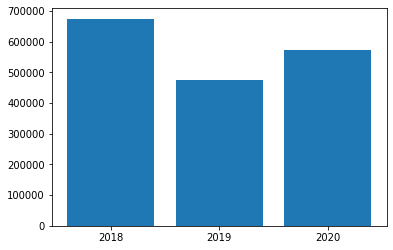

   index  year           계       증가량
1    289  2018  23202555.0  674260.0
2    289  2019  23677366.0  474811.0
3    289  2020  24250946.0  573580.0


In [163]:
bar_chart = car_year_status_df[['year','계']]

# 이상한 인덱스가 들어가서, 인덱스 재 설정 
bar_chart.reset_index(drop=False, inplace=True)

bar_chart['증가량'] = 0

for i in range(1, len(bar_chart)):
    bar_chart.loc[i,'증가량'] = bar_chart.loc[i,'계'] - bar_chart.loc[i - 1,'계']

plt.bar(bar_chart.year[1:], bar_chart.증가량[1:])
plt.show()
print(bar_chart[1:])

차량 증가 동향을 보면, 2018년에 67만건, 2019년에는 그보다 감소한 47만 5천건, 2020년 10월 기준 57만 3580건에 해당함을 알수 있다.

이를 친환경 / 비친환경으로 분류해서 증가 동향을 살펴보면